# Library / Packages

In [1]:
# basic library
import os
import pandas as pd
import numpy as np
import sys


# complex math
from scipy import stats
from scipy.stats import gaussian_kde

# data preparation
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 

# data blueprint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.neighbors import NearestNeighbors

# data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# data cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# data metrics
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix

# data tuning   
from itertools import product
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.calibration import CalibratedClassifierCV

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# pickle and .env
from dotenv import dotenv_values
import pickle

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Data Source

In [5]:
# parameter
share = {**dotenv_values('../.env.shared')} 

# read pickle
with open(share['CLEAN_DATA'], 'rb') as f:
    loaded_data = pickle.load(f)

cc_df = pd.DataFrame(loaded_data)
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   datetime                   294588 non-null  datetime64[ns]
 2   long                       294588 non-null  float64       
 3   lat                        294588 non-null  float64       
 4   zipcode                    294588 non-null  int64         
 5   state                      294588 non-null  object        
 6   city                       294588 non-null  object        
 7   date                       294588 non-null  object        
 8   year                       294588 non-null  int32         
 9   quarter                    294588 non-null  object        
 10  month                      294588 non-null  object        
 11  season                     294588 non-null  object  

In [6]:
cc_df.head()

,credit_card,datetime,long,lat,zipcode,state,city,date,year,quarter,month,season,week_cat,day,time,limit_cat,transaction_dollar_amount,prev_time,time_diff_hour,prev_long,prev_lat,distance_km,geo_cat,speed_km/h,fraud,cc_id,trx_id
0,9484591448272784,2015-07-31 09:39:48,-90.045639,29.889039,70112,la,new orleans,2015-07-31,2015,2015Q3,july,summer,weekday,friday,09:39:48,very_low,17.99,2015-10-27 20:34:03,2122.90,-90.151504,29.945202,11.969568,normal,0.01,not_fraud,fa5cc43fa04e2dfdfd63c16638d485b95c679d6ad56e63...,7c7b74141d438a10410c6af617c405f596b23d6691c0ca...
1,7053196367895112,2015-07-31 11:03:48,-74.027561,40.689615,10001,ny,new york,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:03:48,low,12.09,2015-08-29 17:05:27,702.03,-73.927029,40.806511,15.511210,normal,0.02,not_fraud,d578d6057e09202141d896fdf5225e21b2e9667f811425...,bbbdacccde18af756cea741863cdc2315eeb5da20e4d03...
2,9528285469413252,2015-07-31 11:10:14,-72.139485,43.108100,3280,nh,washington,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:10:14,very_high,78.21,2015-10-14 19:06:04,1807.93,-72.064113,43.172281,9.404226,normal,0.01,not_fraud,c7609a7d7ae21b8f05b5939c23fd70443565a030a4f3e7...,2bc2b25359ae1ffe5ef9e8b539a816536971f88f6bf76e...
3,1845720274833905,2015-07-31 11:28:55,-89.002148,40.804323,61738,il,el paso,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:28:55,medium,74.41,2015-08-29 19:33:54,704.08,-88.974492,40.720877,9.556419,normal,0.01,not_fraud,08dd431e05754307851c422032d9ce2dedd05ea72dd3a4...,b19ee38c1def42021e0624b7c0ede907bb41175e4ac34e...
4,7850942767136368,2015-07-31 11:38:51,-72.025675,43.210753,3280,nh,washington,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:38:51,very_low,54.89,2015-08-21 03:39:50,496.02,-72.125392,43.219223,8.157130,normal,0.02,not_fraud,0e208305f2f8ec7b8660e2dc8a25761481b399e1d8c254...,6da26f20cbea17f6e4af469994b21641aac2784a5e53cc...


## Check Imbalanced Data

### Proportion

In [7]:
# Check proportion
print(f'{cc_df["fraud"].value_counts()} \n')
print(round(cc_df["fraud"].value_counts(normalize = True) * 100, 2))

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64 

fraud
not_fraud    95.98
fraud         4.02
Name: proportion, dtype: float64


### Imbalance Ratio

In [8]:
# 
minority_class = cc_df["fraud"].value_counts().min()
majority_class = cc_df["fraud"].value_counts().max()

# 
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")

Imbalance Ratio (IR): 23.87


# Data Modeling

### Check Irrelevant Data

#### Threshold Methode 

In [9]:
from sklearn.feature_selection import VarianceThreshold

# Drop kolom non-numerik
df_numeric = cc_df.select_dtypes(include = ['number'])
print(f'numeric columns: {df_numeric.columns}\n')

# Inisialisasi VarianceThreshold (misalnya, ambang batas 0.01)
selector = VarianceThreshold(threshold = 0.01)
df_var_selected = selector.fit_transform(df_numeric)

# Fitur yang dipertahankan
selected_features = df_numeric.columns[selector.get_support()]
print("Fitur yang dipertahankan:", selected_features)

numeric columns: Index(['credit_card', 'long', 'lat', 'zipcode', 'year',
       'transaction_dollar_amount', 'time_diff_hour', 'prev_long', 'prev_lat',
       'distance_km', 'speed_km/h'],
      dtype='object')

Fitur yang dipertahankan: Index(['credit_card', 'long', 'lat', 'zipcode', 'transaction_dollar_amount',
       'time_diff_hour', 'prev_long', 'prev_lat', 'distance_km', 'speed_km/h'],
      dtype='object')


In [10]:
# Seleceted numeric columns
filter_numeric = ['long', 'lat', 'prev_long', 'prev_lat', 'credit_card', 'zipcode']
selected_numeric = selected_features.drop(filter_numeric)

#
print("Numeric column untuk modeling:", selected_numeric)

Numeric column untuk modeling: Index(['transaction_dollar_amount', 'time_diff_hour', 'distance_km',
       'speed_km/h'],
      dtype='object')


#### Relevant Column

In [11]:
# Check Column Category
check_cat = cc_df.select_dtypes(include = ['object'])

for i in check_cat.columns:
    unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
    unique_count = check_cat[i].nunique()  # Menghitung jumlah unik
    print(f'{i.upper()} \t: {unique_values}')
    print(f'{"-" * 50} \n')

STATE 	: ['la' 'ny' 'nh' 'il' 'pa' 'nj' 'mo' 'md' 'ca' 'tx' 'me' 'vt' 'al' 'wv'
 'pr' 'wa' 'nc' 'ga' 'ma' 'ok' 'mi' 'ut' 'fl' 'hi' 'ia' 'nm' 'oh' 'az'
 'va' 'in' 'ri' 'id' 'co' 'ct' 'ks']
-------------------------------------------------- 

CITY 	: ['new orleans' 'new york' 'washington' 'el paso' 'dallas' 'houston'
 'birmingham' 'kansas city' 'austin' 'pasadena' 'los angeles' 'fort worth'
 'jackson' 'pittsburgh' 'portland' 'albany' 'charlotte' 'huntsville'
 'madison' 'orlando' 'san antonio' 'seattle' 'minneapolis' 'sacramento'
 'san francisco' 'memphis' 'dayton' 'denver' 'milwaukee' 'omaha' 'trenton'
 'springfield' 'phoenix' 'oklahoma city' 'charleston' 'miami' 'long beach'
 'quitman' 'saint louis' 'friendship' 'chicago' 'salt lake city'
 'richmond' 'pensacola' 'san diego' 'atlanta' 'honolulu' 'greensboro'
 'newark' 'rochester' 'lafayette' 'columbus' 'staten island' 'des moines'
 'las vegas' 'chester' 'cincinnati' 'hillsboro' 'tucson' 'buffalo'
 'arlington' 'shreveport' 'philadelphia' 

In [12]:
for i in check_cat.columns:
    unique_count = check_cat[i].nunique()  # Menghitung jumlah nilai unik
    
    if unique_count > 10:  # Filter hanya kolom dengan nilai unik lebih dari 10
        unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
        # print(f'{i.upper()} \t: {unique_values}')
        print(f'Jumlah unik {i.upper()} \t: {unique_count}')
        print(f'{"-" * 50} \n')


Jumlah unik STATE 	: 35
-------------------------------------------------- 

Jumlah unik CITY 	: 124
-------------------------------------------------- 

Jumlah unik DATE 	: 92
-------------------------------------------------- 

Jumlah unik TIME 	: 51419
-------------------------------------------------- 

Jumlah unik CC_ID 	: 294588
-------------------------------------------------- 

Jumlah unik TRX_ID 	: 294588
-------------------------------------------------- 



In [13]:
# Drop kolom numerik
df_obj = cc_df.select_dtypes(include = ['object'])
print(f'objetc columns: {df_obj.columns}\n')

objetc columns: Index(['state', 'city', 'date', 'quarter', 'month', 'season', 'week_cat',
       'day', 'time', 'limit_cat', 'geo_cat', 'fraud', 'cc_id', 'trx_id'],
      dtype='object')



In [14]:
# selected object columns
filter_obj = ['city', 'limit_cat', 'fraud', 'geo_cat']
selected_object = df_obj[filter_obj].columns

#
print("Object column untuk modeling:", selected_object)

Object column untuk modeling: Index(['city', 'limit_cat', 'fraud', 'geo_cat'], dtype='object')


In [15]:
# 
trans_col = selected_numeric.append(selected_object)

# 
trans_col = cc_df[trans_col]
trans_col.head()

,transaction_dollar_amount,time_diff_hour,distance_km,speed_km/h,city,limit_cat,fraud,geo_cat
0,17.99,2122.90,11.969568,0.01,new orleans,very_low,not_fraud,normal
1,12.09,702.03,15.511210,0.02,new york,low,not_fraud,normal
2,78.21,1807.93,9.404226,0.01,washington,very_high,not_fraud,normal
3,74.41,704.08,9.556419,0.01,el paso,medium,not_fraud,normal
4,54.89,496.02,8.157130,0.02,washington,very_low,not_fraud,normal


In [16]:
# 
print("Proporsi Target Data:")
print(f"Total Rows: {len(trans_col)}")
print(trans_col["fraud"].value_counts(normalize=True) * 100, '\n')
print(trans_col["fraud"].value_counts())

Proporsi Target Data:
Total Rows: 294588
fraud
not_fraud    95.978791
fraud         4.021209
Name: proportion, dtype: float64 

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64


### Check Noise Data

#### Boxplot

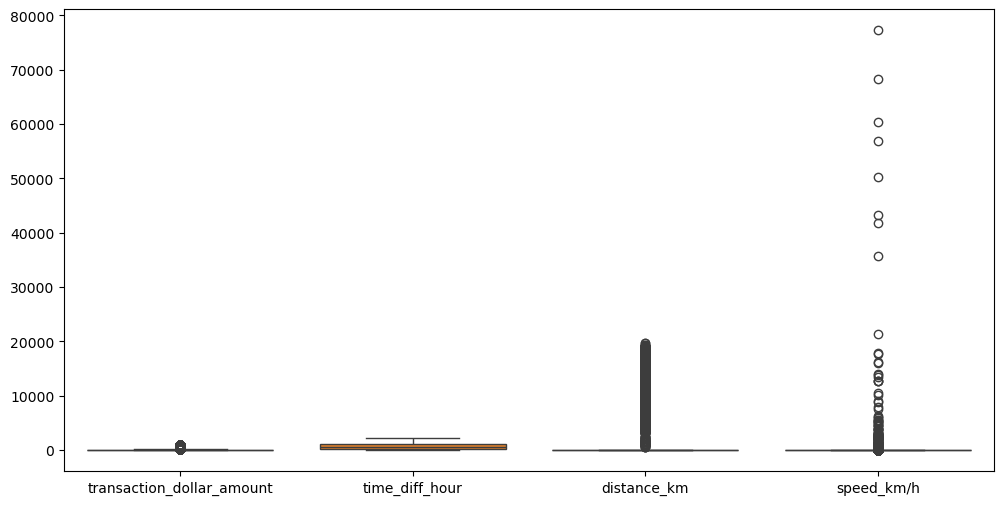

In [17]:
plt.figure(figsize = (12,6))
sns.boxplot(data = trans_col.select_dtypes(include = ["number"])) 
plt.show()

#### Z-Score

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Kolom numerik yang ingin dicek outliernya
num_cols = ["transaction_dollar_amount", "distance_km"]

# Hitung z-score
z_scores = np.abs(zscore(trans_col[num_cols]))

# Tandai data yang memiliki outlier
outlier_mask = (z_scores > 3).any(axis=1)

# Jumlah outlier sebelum Winsorization
num_outliers_before = outlier_mask.sum()
print(f"Jumlah outlier yang terdeteksi: {num_outliers_before} \n")

Jumlah outlier yang terdeteksi: 14158 



#### Winsorization

In [19]:
# clip_percent = 2.4

# # Winsorization hanya untuk data "not_fraud"
# for col in num_cols:
#     lower = np.percentile(trans_col[trans_col["fraud"] == "not_fraud"][col], clip_percent)
#     upper = np.percentile(trans_col[trans_col["fraud"] == "not_fraud"][col], 100 - clip_percent)

#     trans_col.loc[trans_col["fraud"] == "not_fraud", col] = np.clip(
#         trans_col.loc[trans_col["fraud"] == "not_fraud", col], lower, upper
#     )

# # Cek apakah outlier masih ada setelah Winsorization
# z_scores_after = np.abs(zscore(trans_col[num_cols]))
# outlier_mask_after = (z_scores_after > 3).any(axis=1)

# num_outliers_after = outlier_mask_after.sum()
# print(f"Jumlah outlier setelah Winsorization: {num_outliers_after} \n")

In [20]:
# # Visualisasi dengan subplot
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Boxplot untuk transaction_dollar_amount
# sns.boxplot(x = "fraud", y = "transaction_dollar_amount", hue = "fraud", 
#             data = trans_col, ax = axes[0], palette = "Set2", legend = False)

# axes[0].set_title("Distribusi Transaction Dollar Amount Berdasarkan Fraud Status")
# axes[0].set_ylabel("Transaction Dollar Amount")
# axes[0].set_xlabel("Fraud Status")
# axes[0].grid(axis = "y", linestyle = "--", alpha = 0.7)

# # Boxplot untuk distance
# sns.boxplot(x = "fraud", y = "distance_km", hue = "fraud", 
#             data = trans_col, ax = axes[1], palette = "Set2", legend = False)

# axes[1].set_title("Distribusi Distance Berdasarkan Fraud Status")
# axes[1].set_ylabel("Distance")
# axes[1].set_xlabel("Fraud Status")
# axes[1].grid(axis = "y", linestyle = "--", alpha = 0.7)

# # Tambahkan anotasi jumlah outlier
# for ax in axes:
#     ax.annotate(f"Outlier Sebelum: {num_outliers_before}", xy = (0.5, 0.95), xycoords = "axes fraction", 
#                 ha = "center", fontsize = 10, color = "red", fontweight = "bold")
    
#     ax.annotate(f"Outlier Setelah: {num_outliers_after}", xy = (0.5, 0.90), xycoords = "axes fraction", 
#                 ha = "center", fontsize = 10, color = "green", fontweight = "bold")

# plt.tight_layout()
# plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Pastikan trans_col adalah salinan eksplisit
trans_col = trans_col.copy()

# Kolom numerik yang ingin dicek outliernya
num_cols = ["transaction_dollar_amount", "distance_km", "speed_km/h"]

# Hitung z-score sebelum transformasi
z_scores = np.abs(zscore(trans_col[num_cols]))
outlier_mask = (z_scores > 3).any(axis=1)
num_outliers_before = outlier_mask.sum()

# Winsorization hanya untuk data "not_fraud"
clip_percent = 2.4
for col in num_cols:
    lower = np.percentile(trans_col.loc[trans_col["fraud"] == "not_fraud", col], clip_percent)
    upper = np.percentile(trans_col.loc[trans_col["fraud"] == "not_fraud", col], 100 - clip_percent)
    trans_col.loc[trans_col["fraud"] == "not_fraud", col] = np.clip(
        trans_col.loc[trans_col["fraud"] == "not_fraud", col].values, lower, upper
    )

# Log Transformation untuk semua data (hindari nilai negatif)
for col in num_cols:
    trans_col.loc[:, col] = np.log1p(trans_col[col].clip(lower=0).values)

# Robust Scaling untuk semua data
scaler = RobustScaler()
trans_col.loc[:, num_cols] = scaler.fit_transform(trans_col[num_cols].values)

# Power Transformation (Yeo-Johnson) untuk semua data
pt = PowerTransformer(method='yeo-johnson')
trans_col.loc[:, num_cols] = pt.fit_transform(trans_col[num_cols].values)

# IQR Capping untuk semua data
for col in num_cols:
    Q1 = trans_col[col].quantile(0.25)
    Q3 = trans_col[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    trans_col.loc[:, col] = np.where(
        trans_col[col].values < lower_bound, lower_bound,
        np.where(trans_col[col].values > upper_bound, upper_bound, trans_col[col].values)
    )

# Hitung z-score setelah transformasi
z_scores_after = np.abs(zscore(trans_col[num_cols]))
outlier_mask_after = (z_scores_after > 3).any(axis=1)
num_outliers_after = outlier_mask_after.sum()

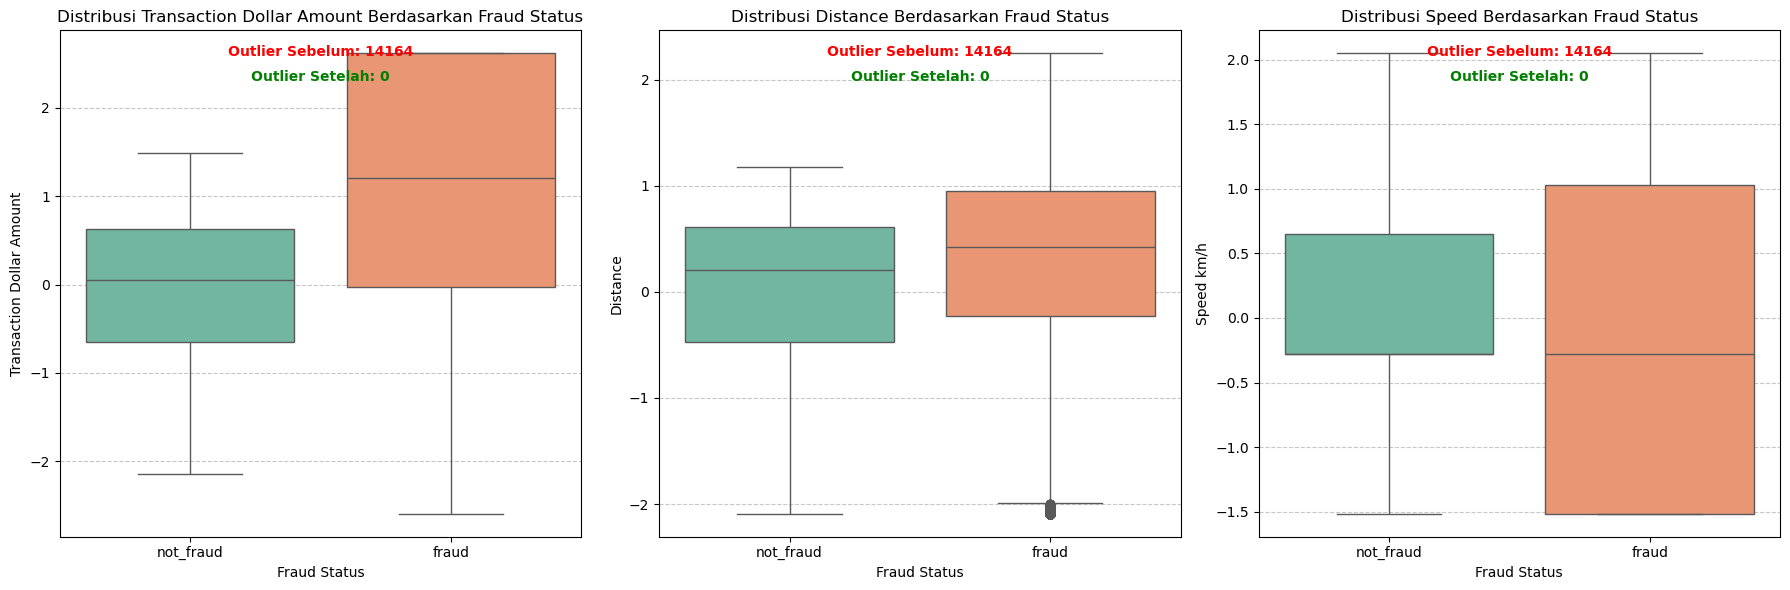

In [22]:
# Hitung z-score setelah transformasi
z_scores_after = np.abs(zscore(trans_col[num_cols]))
outlier_mask_after = (z_scores_after > 3).any(axis=1)
num_outliers_after = outlier_mask_after.sum()

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x="fraud", y="transaction_dollar_amount", hue="fraud", 
            data=trans_col, ax=axes[0], palette="Set2", legend=False)
axes[0].set_title("Distribusi Transaction Dollar Amount Berdasarkan Fraud Status")
axes[0].set_ylabel("Transaction Dollar Amount")
axes[0].set_xlabel("Fraud Status")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x="fraud", y="distance_km", hue="fraud", 
            data=trans_col, ax=axes[1], palette="Set2", legend=False)
axes[1].set_title("Distribusi Distance Berdasarkan Fraud Status")
axes[1].set_ylabel("Distance")
axes[1].set_xlabel("Fraud Status")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x="fraud", y="speed_km/h", hue="fraud", 
            data=trans_col, ax=axes[2], palette="Set2", legend=False)
axes[2].set_title("Distribusi Speed Berdasarkan Fraud Status")
axes[2].set_ylabel("Speed km/h")
axes[2].set_xlabel("Fraud Status")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

# Tambahkan anotasi jumlah outlier
for ax in axes:
    ax.annotate(f"Outlier Sebelum: {num_outliers_before}", xy=(0.5, 0.95), xycoords="axes fraction", 
                ha="center", fontsize=10, color="red", fontweight="bold")
    ax.annotate(f"Outlier Setelah: {num_outliers_after}", xy=(0.5, 0.90), xycoords="axes fraction", 
                ha="center", fontsize=10, color="green", fontweight="bold")

plt.tight_layout()
plt.show()

## Transform Data

In [23]:
# Ensure Data Consistency (before after same after winsorization)
print("Proporsi Label Setelah Preprocessing: ")
print("=" * 50)

print(trans_col["fraud"].value_counts(normalize = True) * 100, '\n')
print(trans_col["fraud"].value_counts())

Proporsi Label Setelah Preprocessing: 
fraud
not_fraud    95.978791
fraud         4.021209
Name: proportion, dtype: float64 

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64


In [24]:
# remove NaN from target
trans_df = trans_col.dropna(subset = ['fraud'])

# check value
print(round(trans_df["fraud"].value_counts(normalize = True) * 100, 2), "\n")
print(trans_df["fraud"].value_counts())

fraud
not_fraud    95.98
fraud         4.02
Name: proportion, dtype: float64 

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64


### Split Data

In [25]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# split data
X = trans_df.drop(columns = ["fraud"]).copy()
y = trans_df["fraud"].copy()

# 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_dollar_amount  294588 non-null  float64
 1   time_diff_hour             294588 non-null  float64
 2   distance_km                294588 non-null  float64
 3   speed_km/h                 294588 non-null  float64
 4   city                       294588 non-null  object 
 5   limit_cat                  294588 non-null  object 
 6   geo_cat                    294588 non-null  object 
dtypes: float64(4), object(3)
memory usage: 15.7+ MB


In [26]:
# Split data sebelum preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Konversi target ke numeric (setelah split)
y_train = y_train.map({"not_fraud": 0, "fraud": 1})
y_test = y_test.map({"not_fraud": 0, "fraud": 1})

# Menampilkan informasi dataset
print("=" * 50)
print("Data has been split!!! \n")
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("=" * 50)

Data has been split!!! 

Train set size: 235670
Test set size: 58918


### Grouping Category

In [27]:
# Daftar kolom untuk label encoding (kolom ordinal)
ordinal_set = {'limit_cat'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
ordinal_cols, ohe_cols, label_cols, numeric_cols = [], [], [], []

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

    elif X[col].dtype == 'object' or X[col].dtype.name == "category":
        unique_count = X[col].nunique()  # Menghitung jumlah unik
        
        if col in ordinal_set:
            ordinal_cols.append(col)
            
        elif unique_count > 10:  # Jika nilai unik lebih dari 10 → label encoding
            label_cols.append(col)
            
        else:  # Jika nilai unik <= 10 → one-hot encoding
            ohe_cols.append(col)

# Menampilkan hasil
print("Ordinal Columns: \t", ordinal_cols)
print("One-Hot Columns: \t", ohe_cols)
print("Label Columns: \t\t", label_cols)
print("Numeric Columns: \t", numeric_cols)

Ordinal Columns: 	 ['limit_cat']
One-Hot Columns: 	 ['geo_cat']
Label Columns: 		 ['city']
Numeric Columns: 	 ['transaction_dollar_amount', 'time_diff_hour', 'distance_km', 'speed_km/h']


In [28]:
# Check Ordinal Columns
for i in ordinal_cols:
    print(f'{i.upper()} \t: {check_cat[i].unique()}')
    print(f'{"-" * 50}')

LIMIT_CAT 	: ['very_low' 'low' 'very_high' 'medium' 'high']
--------------------------------------------------


In [29]:
# Menentukan urutan kategori masing-masing kolom
oridnal_cat = [
    ["very_low", "low", "medium", "high", "very_high"],   # Urutan untuk limit_cat
]

### Transform Parameter

In [30]:
# Transformasi
numerical_tf = RobustScaler(with_centering = True,          # Jika True, akan mengurangi median sebelum scaling 
                            with_scaling = True,            # Jika True, akan membagi dengan IQR 
                            quantile_range = (25.0, 75.0),  # Rentang persentil untuk IQR (default: Q1=25%, Q3=75%) 
                            unit_variance = False,          # Jika True, akan menyesuaikan data agar memiliki varians sekitar 1 
                            copy = False                    # Jika False, transformasi dilakukan in-place pada array input 
                            )

ohe_tf = OneHotEncoder(handle_unknown = 'ignore', 
                       sparse_output = True, 
                       max_categories = 50
                       )

ordinal_tf = OrdinalEncoder(categories = oridnal_cat, 
                            handle_unknown = 'use_encoded_value', 
                            unknown_value = -1
                            )

# Fungsi untuk Label Encoding
def label_encode_columns(X):
    X = X.copy()  # Hindari mengubah DataFrame asli
    for col in label_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        
    return X

In [31]:
# Column Transformer dengan FunctionTransformer
prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric_cols),  # Standarisasi numerik
        ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output = True, max_categories = 50), ohe_cols), 
        ("label", FunctionTransformer(label_encode_columns, validate = False), label_cols),  # Label encoder in pipeline
        ("ord", OrdinalEncoder(categories = oridnal_cat, handle_unknown = "use_encoded_value", unknown_value = -1), ordinal_cols)
    ], remainder = "passthrough")

In [32]:
X_train_tf = prep_stage_2.fit_transform(X_train)  # Fit & Transform Training Data
X_test_tf = prep_stage_2.transform(X_test)  # Transform Test Data

In [33]:
# get feature names after pipeline
num_features = numeric_cols 
cat_features = prep_stage_2.named_transformers_["ohe"].get_feature_names_out(ohe_cols) 
ord_features = ordinal_cols 
label_features = label_cols 

# combine column
transformed_columns = (list(num_features) + 
                       list(cat_features) + 
                       list(ord_features) + 
                       list(label_features)) 

# Dataframe after transform
df_X_train_tf = pd.DataFrame(X_train_tf, columns=transformed_columns)
print(f'Total rows X_train resample: {df_X_train_tf.shape} \n')

df_X_test_tf = pd.DataFrame(X_test_tf, columns=transformed_columns)
print(f'Total rows X_test resample: {df_X_test_tf.shape}')


Total rows X_train resample: (235670, 8) 

Total rows X_test resample: (58918, 8)


### Re-Sampling

In [34]:
# Check Target Proportion
print("Check Data:")
print(f"{y_train.value_counts(normalize = True) * 100} \n")
print(y_train.value_counts())

Check Data:
fraud
0    95.978699
1     4.021301
Name: proportion, dtype: float64 

fraud
0    226193
1      9477
Name: count, dtype: int64


In [35]:
# 
smote = SMOTE(sampling_strategy = 0.1, random_state = 42)
X_train_resample, y_train_resample = smote.fit_resample(X_train_tf, y_train)

In [36]:
# Train Resampling
print("After Resampling:")
print(f"{y_train_resample.value_counts(normalize = True) * 100} \n")
print(y_train_resample.value_counts())

After Resampling:
fraud
0    90.909201
1     9.090799
Name: proportion, dtype: float64 

fraud
0    226193
1     22619
Name: count, dtype: int64


### Leak Checking

#### Train Data

In [37]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_train_leak = pd.DataFrame(X_train_resample, columns = df_X_train_tf.columns)

# Cek korelasi antara fitur dan label
print(X_train_leak.corrwith(pd.Series(y_train_resample)))

transaction_dollar_amount    0.341967
time_diff_hour              -0.214957
distance_km                  0.167028
speed_km/h                  -0.055639
geo_cat_anomaly              0.592683
geo_cat_normal              -0.592683
limit_cat                   -0.009354
city                        -0.006086
dtype: float64


In [38]:
# Check High Correlations
correlation_values = X_train_leak.corrwith(pd.Series(y_train_resample))
high_correlation_features = correlation_values[correlation_values.abs() > 0.9]

print(high_correlation_features)

Series([], dtype: float64)


In [39]:
X_train_leak = X_train_leak.drop(columns = high_correlation_features.index)
X_train_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248812 entries, 0 to 248811
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_dollar_amount  248812 non-null  float64
 1   time_diff_hour             248812 non-null  float64
 2   distance_km                248812 non-null  float64
 3   speed_km/h                 248812 non-null  float64
 4   geo_cat_anomaly            248812 non-null  float64
 5   geo_cat_normal             248812 non-null  float64
 6   limit_cat                  248812 non-null  float64
 7   city                       248812 non-null  float64
dtypes: float64(8)
memory usage: 15.2 MB


#### Test Data

In [40]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_test_leak = pd.DataFrame(df_X_test_tf, columns = df_X_test_tf.columns)

# Cek korelasi antara fitur dan label
print(X_test_leak.corrwith(pd.Series(y_test)))

transaction_dollar_amount    0.012137
time_diff_hour              -0.014984
distance_km                  0.000052
speed_km/h                   0.004458
geo_cat_anomaly              0.001801
geo_cat_normal              -0.001801
limit_cat                   -0.001634
city                         0.024632
dtype: float64


In [41]:
X_test_leak = X_test_leak.drop(columns = high_correlation_features.index, errors = "ignore")
X_test_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58918 entries, 0 to 58917
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_dollar_amount  58918 non-null  float64
 1   time_diff_hour             58918 non-null  float64
 2   distance_km                58918 non-null  float64
 3   speed_km/h                 58918 non-null  float64
 4   geo_cat_anomaly            58918 non-null  float64
 5   geo_cat_normal             58918 non-null  float64
 6   limit_cat                  58918 non-null  float64
 7   city                       58918 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


## Pipeline Blueprint

In [42]:
# Rename var train
X_train_mod = X_train_leak.copy()
y_train_mod = y_train_resample.copy()

# Rename var test
X_test_mod = X_test_leak.copy()
y_test_mod = y_test.copy()

### Model Selections

#### Logistic Regression

In [43]:
logreg_model = LogisticRegression(solver = "liblinear", 
                                #   class_weight = "balanced",
                                  C = 0.5,  # Tambahkan regularisasi
                                  penalty = "l2",
                                  random_state = 42)

#### Decission Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth = 5, 
                                #   class_weight = "balanced", 
                                  random_state = 42)

#### Random Forest

In [45]:
forest_model = RandomForestClassifier(n_estimators = 100,  # Kurangi jumlah pohon
                                      max_depth = 5,  # Kurangi kedalaman pohon
                                      min_samples_split = 10,  # Cegah overfitting
                                    #   class_weight = "balanced",
                                      random_state = 42)

#### XGBoost

In [46]:
# Tangani kasus ZeroDivisionError jika kelas minoritas tidak ada di y_train
if np.sum(y_train_resample == 1) == 0:
    scale_pos_weight = 1
    
else:
    scale_pos_weight = np.sum(y_train_resample == 0) / np.sum(y_train_resample == 1)

In [47]:
xgb_model = XGBClassifier(n_estimators = 500, 
                        #   scale_pos_weight = scale_pos_weight,
                          learning_rate = 0.05, 
                          max_depth = 3,  
                          subsample = 0.8, 
                          colsample_bytree = 0.8,  
                          reg_alpha = 0.1,  # Regularisasi L1
                          reg_lambda = 0.5,  # Regularisasi L2
                          eval_metric = "aucpr",
                          random_state = 42)

#### LightBGM

In [48]:
lbgm_model = LGBMClassifier(is_unbalance = True, 
                            force_col_wise = True, 
                            max_depth = 10,  # Menambah kedalaman pohon 
                            min_data_in_leaf = 10,  # Menghindari split yang tidak berguna 
                            eval_metric = "logloss",  # Metode evaluasi yang lebih jelas 
                            verbose = -1,  # Mengurangi log yang berlebihan 
                            random_state = 42)

#### CatBoost

In [49]:
catb_model = CatBoostClassifier(verbose = 0, 
                                # auto_class_weights = 'Balanced', 
                                random_state = 42)

#### Pipeline Methode

In [50]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Menyimpan semua pipeline dalam dictionary
pipelines = {
    "Logistic Regression": logreg_model,
    "Decission Tree": dt_model, 
    "Random Forest": forest_model,
    "XGBoost": xgb_model,
    "LightGBM": lbgm_model,
    "CatBoost": catb_model
}

# Evaluasi semua model
best_ap_test = 0  
best_score_diff = float("inf")  
best_model = None
best_model_name = ""

for name, pipe in pipelines.items():
    print(f"🔹 Evaluasi Model: {name}")
    print('=' * 50)
    
    # Training model
    if name == "CatBoost":
        pipe.fit(X_train_mod, y_train_mod, verbose=False)
    else:
        pipe.fit(X_train_mod, y_train_mod)
    
    # === Train Evaluation ===
    y_train_pred_proba = pipe.predict_proba(X_train_mod)[:, 1]
    ap_train = average_precision_score(y_train_mod, y_train_pred_proba)
    print(f"📊 Average Precision Score (Train): {ap_train:.3f}")

    # === Test Evaluation ===
    y_test_pred_proba = pipe.predict_proba(X_test_mod)[:, 1]
    ap_test = average_precision_score(y_test_mod, y_test_pred_proba)
    
    # Filter model jika AP Score terlalu tinggi
    if ap_test > 0.95:
        print(f"⚠️ AP Score Test terlalu tinggi ({ap_test:.3f}), model ini diabaikan.\n")
        continue  

    print(f"📊 Average Precision Score (Test): {ap_test:.3f}")

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
    
    # Cari threshold optimal
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari divisi oleh nol
    best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5
    print(f"🎯 Optimal Threshold: {best_threshold:.3f}")

    # Konversi probabilitas menjadi label menggunakan threshold optimal
    y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_test_mod, y_test_pred))

    print('=' * 50, '\n')

    # Evaluasi model terbaik berdasarkan AP Score Test dan perbedaan train-test terkecil
    score_diff = abs(ap_train - ap_test)

    if ap_test > best_ap_test or (ap_test == best_ap_test and score_diff < best_score_diff):
        best_model = pipe
        best_model_name = name
        best_ap_test = ap_test
        best_score_diff = score_diff

# Menampilkan hasil akhir
if best_model is not None:
    print(f"🏆 Model Terbaik: {best_model_name} dengan AP Score Test tertinggi: {best_ap_test:.3f} dan perbedaan AP Score: {best_score_diff:.3f}")
else:
    print("❌ Tidak ada model yang memenuhi syarat (AP Score Test ≤ 0.95).")


🔹 Evaluasi Model: Logistic Regression
📊 Average Precision Score (Train): 0.962
📊 Average Precision Score (Test): 0.927
🎯 Optimal Threshold: 0.479

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56549
           1       0.87      0.90      0.88      2369

    accuracy                           0.99     58918
   macro avg       0.93      0.95      0.94     58918
weighted avg       0.99      0.99      0.99     58918


🔹 Evaluasi Model: Decission Tree
📊 Average Precision Score (Train): 1.000
⚠️ AP Score Test terlalu tinggi (1.000), model ini diabaikan.

🔹 Evaluasi Model: Random Forest
📊 Average Precision Score (Train): 1.000
⚠️ AP Score Test terlalu tinggi (1.000), model ini diabaikan.

🔹 Evaluasi Model: XGBoost
📊 Average Precision Score (Train): 1.000
⚠️ AP Score Test terlalu tinggi (1.000), model ini diabaikan.

🔹 Evaluasi Model: LightGBM
📊 Average Precision Score (Train): 1.000
⚠️ AP Score Test terlalu ting

#### Voting Methode

In [51]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve

# Membuat Voting Classifier dengan model terbaik
voting_clf = VotingClassifier(
    estimators=[
        ('rf', forest_model),
        ('dt', dt_model), 
        ('xgb', xgb_model),
        ('lgbm', lbgm_model),
        ('catb', catb_model)
    ],
    voting='soft'  # Menggunakan probabilitas
)

# Training Voting Classifier
voting_clf.fit(X_train_mod, y_train_mod)

# Evaluasi pada Test Set
y_test_pred_proba_voting = voting_clf.predict_proba(X_test_mod)[:, 1]

# Hitung Average Precision Score (AP Score) untuk Voting Classifier
best_ap_voting = average_precision_score(y_test_mod, y_test_pred_proba_voting)

# Filter jika AP Score Voting Classifier terlalu tinggi
if best_ap_voting > 0.95:
    print(f"⚠️ AP Score Voting Classifier terlalu tinggi ({best_ap_voting:.3f}), model ini diabaikan.")
    best_ap_voting = 0  # Abaikan model ini dari pemilihan final
else:
    print(f"📊 Average Precision Score (Voting Classifier): {best_ap_voting:.3f}")

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba_voting)

    # Cari threshold optimal
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari divisi oleh nol
    best_threshold_voting = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5
    print(f"🎯 Optimal Threshold: {best_threshold_voting:.3f}")

    # Konversi probabilitas menjadi label menggunakan threshold optimal
    y_test_pred_voting = (y_test_pred_proba_voting >= best_threshold_voting).astype(int)

    # Evaluasi Voting Classifier
    print("\n=== Classification Report (Voting Classifier) ===")
    print(classification_report(y_test_mod, y_test_pred_voting)) 


⚠️ AP Score Voting Classifier terlalu tinggi (1.000), model ini diabaikan.


### Choosing Best Model

In [52]:
final_model = None
final_model_name = ""
final_score = 0

if best_ap_voting > best_ap_test:
    final_model = voting_clf
    final_model_name = "Voting Classifier"
    final_score = best_ap_voting
elif best_ap_test > 0:
    final_model = best_model
    final_model_name = best_model_name
    final_score = best_ap_test

# Menampilkan model terbaik
if final_model is not None:
    print(f"✅ Model Terbaik untuk CV: {final_model_name} dengan Average Precision Score: {final_score:.3f}")
else:
    print("❌ Tidak ada model yang memenuhi syarat (AP Score Test ≤ 0.95).")

✅ Model Terbaik untuk CV: Logistic Regression dengan Average Precision Score: 0.927


## Finding Optimal CV

In [53]:
# Daftar nilai CV yang ingin diuji
cv_values = [3, 5, 7, 10]
testing_best_cv = None
testing_cv_score = 0

print("🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...")

for cv in cv_values:
    print(f"\nEvaluasi dengan cv = {cv}")
    
    # Gunakan StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 42)
    print(f"stratified_cv: {stratified_cv}")
    
    scores = cross_val_score(final_model, 
                             X_train_mod, 
                             y_train_mod, 
                             cv = stratified_cv, 
                             scoring = 'average_precision', 
                             n_jobs = -1)
    
    mean_score = np.mean(scores)  # ✅ Gunakan rata-rata, bukan max
    print(f"average_precision rata-rata: {mean_score:.3f} (dengan cv = {cv})")
    
    # Simpan nilai CV terbaik
    if mean_score > testing_cv_score:
        testing_cv_score = mean_score
        testing_best_cv = cv

print(f"\n✅ Nilai CV Optimal: {testing_best_cv} dengan ROC-AUC: {testing_cv_score:.3f}")

🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...

Evaluasi dengan cv = 3
stratified_cv: StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
average_precision rata-rata: 0.962 (dengan cv = 3)

Evaluasi dengan cv = 5
stratified_cv: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
average_precision rata-rata: 0.962 (dengan cv = 5)

Evaluasi dengan cv = 7
stratified_cv: StratifiedKFold(n_splits=7, random_state=42, shuffle=True)
average_precision rata-rata: 0.962 (dengan cv = 7)

Evaluasi dengan cv = 10
stratified_cv: StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
average_precision rata-rata: 0.962 (dengan cv = 10)

✅ Nilai CV Optimal: 3 dengan ROC-AUC: 0.962


In [ ]:
sam = 

# Hyperparameter Tuning

halving

In [54]:
# Pilih model yang akan di-tuning
if final_model_name == "Random Forest":
    param_dist = {
        'n_estimators': [100, 300, 500, 1000],  # Jumlah pohon dalam hutan
        'max_depth': [10, 20, 30, None],  # Kedalaman maksimum pohon
        'min_samples_split': [2, 5, 10, 20],  # Minimum sampel untuk melakukan split
        'min_samples_leaf': [1, 2, 5, 10],  # Minimum sampel di setiap daun
        'max_features': ['sqrt', 'log2', None],  # Fitur yang dipertimbangkan per split
        'bootstrap': [True, False]  # Apakah menggunakan bootstrap sampling
    }

elif final_model_name == "Logistic Regression":
    param_dist = {
        'penalty': ['l1', 'l2', 'elasticnet', None],  # Jenis regularisasi
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parameter inversi dari regularisasi
        'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],  # Algoritma optimasi
        'max_iter': [100, 200, 500, 1000],  # Jumlah iterasi maksimum
        'l1_ratio': [0, 0.1, 0.5, 0.9, 1]  # Hanya berlaku untuk elasticnet
    }


elif final_model_name == "XGBoost":
    param_dist = {
        'n_estimators': [100, 200, 300, 500],  # Jumlah pohon boosting
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'max_depth': [3, 6, 10, 15],  # Kedalaman maksimum pohon
        'min_child_weight': [1, 3, 5, 7],  # Bobot minimum anak untuk split
        'subsample': [0.6, 0.8, 1.0],  # Rasio sampel yang digunakan dalam training
        'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan per pohon
        'gamma': [0, 0.1, 0.2, 0.5],  # Pengendalian pruning dengan minimum loss reduction
        'reg_lambda': [0, 0.1, 1, 10],  # Regularisasi L2
        'reg_alpha': [0, 0.1, 1, 10]  # Regularisasi L1
    }

elif final_model_name == "LightGBM":
    param_dist = {
        'num_leaves': [31, 50, 100, 150],  # Jumlah daun pada setiap pohon
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'n_estimators': [100, 200, 300, 500],  # Jumlah pohon boosting
        'max_depth': [-1, 10, 20, 30],  # Kedalaman maksimum pohon (-1 berarti tidak terbatas)
        'min_child_samples': [10, 20, 50, 100],  # Minimum sampel dalam satu leaf
        'subsample': [0.6, 0.8, 1.0],  # Proporsi sampel yang digunakan
        'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan per pohon
        'reg_lambda': [0, 0.1, 1, 10],  # Regularisasi L2
        'reg_alpha': [0, 0.1, 1, 10]  # Regularisasi L1
    }

elif final_model_name == "CatBoost":
    param_dist = {
        'iterations': [100, 200, 300, 500],  # Jumlah iterasi boosting
        'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Laju pembelajaran
        'depth': [4, 6, 10, 12],  # Kedalaman maksimum pohon
        'l2_leaf_reg': [1, 3, 5, 10],  # Regularisasi L2 untuk leaf
        'bagging_temperature': [0.1, 0.5, 1, 2],  # Kontrol bootstraping (mirip dengan subsample)
        'border_count': [32, 64, 128],  # Jumlah bin untuk fitur numerik
        'random_strength': [0.1, 0.5, 1, 2]  # Noise untuk regularisasi
    }

In [55]:
# from itertools import product

# # Pastikan `final_model_name` memiliki nilai yang valid
# if "final_model_name" not in globals():
#     raise ValueError("Variabel 'final_model_name' belum didefinisikan!")

# # Pilih model yang akan di-tuning
# if final_model_name == "Random Forest":
#     param_dist = {
#         'n_estimators': [100, 300, 500, 1000],
#         'max_depth': [10, 20, 30, None],
#         'min_samples_split': [2, 5, 10, 20],
#         'min_samples_leaf': [1, 2, 5, 10],
#         'max_features': ['sqrt', 'log2', None],
#         'bootstrap': [True, False]
#     }

# elif final_model_name == "XGBoost":
#     param_dist = {
#         'n_estimators': [100, 200, 300, 500],
#         'learning_rate': [0.001, 0.01, 0.1, 0.2],
#         'max_depth': [3, 6, 10, 15],
#         'min_child_weight': [1, 3, 5, 7],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.5],
#         'reg_lambda': [0, 0.1, 1, 10],
#         'reg_alpha': [0, 0.1, 1, 10]
#     }

# elif final_model_name == "LightGBM":
#     param_dist = {
#         'num_leaves': [31, 50, 100, 150],
#         'learning_rate': [0.001, 0.01, 0.1, 0.2],
#         'n_estimators': [100, 200, 300, 500],
#         'max_depth': [-1, 10, 20, 30],
#         'min_child_samples': [10, 20, 50, 100],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'reg_lambda': [0, 0.1, 1, 10],
#         'reg_alpha': [0, 0.1, 1, 10]
#     }

# elif final_model_name == "CatBoost":
#     param_dist = {
#         'iterations': [100, 200, 300, 500],
#         'learning_rate': [0.001, 0.01, 0.1, 0.2],
#         'depth': [4, 6, 10, 12],
#         'l2_leaf_reg': [1, 3, 5, 10],
#         'bagging_temperature': [0.1, 0.5, 1, 2],
#         'border_count': [32, 64, 128],
#         'random_strength': [0.1, 0.5, 1, 2]
#     }

# else:
#     raise ValueError(f"Model '{final_model_name}' tidak dikenali!")


In [56]:
# # 🔹 Pastikan X_train_mod adalah DataFrame
# if isinstance(X_train_mod, np.ndarray):
#     X_train_mod = pd.DataFrame(X_train_mod)

# # 🔹 Bersihkan dataset dari NaN
# X_train_mod = X_train_mod.fillna(X_train_mod.median())

# # 🔹 Bersihkan dataset dari Inf
# X_train_mod = X_train_mod.replace([np.inf, -np.inf], np.nan)  # Ganti Inf jadi NaN
# X_train_mod = X_train_mod.fillna(X_train_mod.median())  # Isi ulang dengan median

# # 🔹 Konversi kembali ke NumPy jika diperlukan
# X_train_mod = X_train_mod.to_numpy()

In [57]:
# 🔹 Hitung jumlah kombinasi parameter jika `param_dist` sudah terdefinisi
if "param_dist" in globals():
    total_combinations = len(list(product(*param_dist.values())))
    print(f"Total kombinasi parameter valid: {total_combinations}")

    # 🔹 Atur `n_candidates` agar tidak lebih besar dari jumlah kombinasi parameter
    param_combinations = min(100, total_combinations)
else:
    raise ValueError("param_dist tidak terdefinisi.")

Total kombinasi parameter valid: 1920


In [58]:
# # Konversi kembali ke DataFrame dengan kolom asli
# X_train_mod = pd.DataFrame(X_train_mod, columns=X_train.columns)
# X_test_mod = pd.DataFrame(X_test_mod, columns=X_test.columns)

# # 🔍 Cek dan Tangani NaN & Inf
# def clean_data(df):
#     # Simpan nama kolom
#     columns = df.columns

#     # Pastikan semua kolom numerik
#     df = df.apply(pd.to_numeric, errors='coerce')

#     # Cek apakah ada NaN atau Inf
#     if np.any(pd.isnull(df)) or np.any(np.isinf(df)):
#         print("⚠️ Warning: Dataset mengandung NaN atau Inf! Membersihkannya...")

#         # Ganti NaN dengan median setiap kolom
#         df = df.fillna(df.median())

#         # Ganti Inf dengan nilai maksimum di setiap kolom
#         df = df.replace([np.inf, -np.inf], df.max())

#     # Pastikan DataFrame tetap memiliki nama kolom
#     df.columns = columns

#     return df

# # 🔹 Bersihkan X_train_mod & X_test_mod
# X_train_mod = clean_data(X_train_mod)
# X_test_mod = clean_data(X_test_mod)

# # 🔍 Cek statistik dataset setelah pembersihan
# print(X_train_mod.describe())


In [59]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# 
skf = StratifiedKFold(n_splits = testing_best_cv, shuffle = True, random_state = 42)

# 🔍 Hyperparameter Tuning dengan HalvingRandomSearchCV
halving_search = HalvingRandomSearchCV(
    final_model, 
    param_distributions = param_dist, 
    factor = 2, # Total combination / factor
    scoring = 'average_precision', 
    cv = skf, 
    n_jobs = -1, 
    random_state = 42,
    n_candidates = param_combinations, 
    error_score = "raise"
)

halving_search.fit(X_train_mod, y_train_mod)

print(f"\n🔍 Hyperparameter Terbaik ({final_model_name}): {halving_search.best_params_}")
print(f"✅ Best ROC-AUC Score: {halving_search.best_score_:.3f}")

optimal_cv = halving_search.best_estimator_

ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

# Final Evaluation

In [ ]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve, roc_auc_score

# 🔹 Konversi ke NumPy untuk menghindari warning
X_test_mod = X_test_mod.to_numpy()

# 🔹 Prediksi dengan Model Terbaik
y_test_pred_proba = optimal_cv.predict_proba(X_test_mod)[:, 1]

# 🔹 Menghitung Average Precision Score (AP Score)
ap_score = average_precision_score(y_test_mod, y_test_pred_proba)
print(f"📊 Average Precision Score (Test): {ap_score:.3f}")

# 🔹 Mencari Threshold Optimal menggunakan Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari pembagian oleh nol
best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5

# 🔹 Gunakan Threshold Optimal untuk Prediksi Akhir
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# 🔹 Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_mod, y_test_pred))

# 🔹 ROC-AUC Score
roc_auc_final = roc_auc_score(y_test_mod, y_test_pred_proba)
print(f"🎯 Final ROC-AUC Score: {roc_auc_final:.3f}")
print(f"🔹 Best Threshold Used: {best_threshold:.3f}")


# Model Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

# 🔹 Precision-Recall Curve
plt.figure(figsize=(10, 5))
precisions, recalls, _ = precision_recall_curve(y_test_mod, y_test_pred_proba)
plt.plot(recalls, precisions, marker='.', label=f'AP Score: {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 🔹 ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, _ = roc_curve(y_test_mod, y_test_pred_proba)
plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC: {roc_auc_final:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 🔹 Histogram Probabilitas Prediksi
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred_proba[y_test_mod == 0], bins=50, label='Non-Fraud', color='blue', alpha=0.6)
sns.histplot(y_test_pred_proba[y_test_mod == 1], bins=50, label='Fraud', color='red', alpha=0.6)
plt.axvline(best_threshold, color='black', linestyle='dashed', label=f'Threshold: {best_threshold:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

In [ ]:
# 🔹 Confusion Matrix
cm = confusion_matrix(y_test_mod, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save Model

In [ ]:
# Tentukan folder tujuan
dir_name = 'datamart'
folder_path = f"../{dir_name}"

# Cek apakah folder sudah ada, jika belum buat foldernya
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
    print(f"Directory '{dir_name}' created successfully.")

else: 
    print(f'Directory has already been created.')